<a href="https://colab.research.google.com/github/IonutCiprian/BDA/blob/main/National_Centers_for_Environmental_Information.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install pyspark
from pyspark.sql import SparkSession

In [71]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("App") \
    .getOrCreate()

In [72]:
import requests
import pandas as pd
import json
import numpy as np
from datetime import datetime
token = 'RUWGUhXJsWYGPeeFgjucwKsNWPdrnaNP'
station_id = 'GHCND:ROE00108895'

In [73]:
#initialize lists to store data
dates_temp = []
dates_prcp = []
temps = []
minT = []
maxT = []
prcp = []

In [93]:
import pandas as pd
import requests

# Setăm token-ul și id-ul stației meteorologice
token = "RUWGUhXJsWYGPeeFgjucwKsNWPdrnaNP"
station_id = "GHCND:ROE00108895"

# Inițializăm un dicționar pentru a stoca datele
data_dict = {'Date': [], 'Min Temperature': [], 'Max Temperature': []}

# Pentru fiecare an de la 2020 la 2023 (inclusiv)...
for year in range(2020, 2024):
    year = str(year)  # Convertim anul în șir de caractere
    print('Lucrăm la anul ' + year)

    # Facem apeluri către API
    r = requests.get(f'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMIN&datatypeid=TMAX&limit=1000&stationid={station_id}&startdate={year}-01-01&enddate={year}-12-31', headers={'token': token})

    # Verificăm dacă cererea a fost cu succes
    if r.status_code == 200:
        # Încărcăm răspunsul API ca JSON
        d = r.json()

        # Obținem toate elementele din răspuns care sunt citiri de temperatură minimă și maximă
        for item in d['results']:
            date = item['date']
            min_temp = item['value'] if item['datatype'] == 'TMIN' else None
            max_temp = item['value'] if item['datatype'] == 'TMAX' else None

            # Adăugăm datele în dicționar
            if date not in data_dict['Date']:
                data_dict['Date'].append(date)
                data_dict['Min Temperature'].append(min_temp)
                data_dict['Max Temperature'].append(max_temp)
            else:
                idx = data_dict['Date'].index(date)
                if min_temp is not None:
                    data_dict['Min Temperature'][idx] = min_temp
                if max_temp is not None:
                    data_dict['Max Temperature'][idx] = max_temp
    else:
        print(f"Request for year {year} failed.")

# Creăm DataFrame-ul
df = pd.DataFrame(data_dict)

# Convertim temperaturile din Fahrenheit în Celsius
df['Min Temperature (C)'] = (df['Min Temperature'] - 32) * 5/9
df['Max Temperature (C)'] = (df['Max Temperature'] - 32) * 5/9

# Ștergem coloanele cu temperaturile în Fahrenheit
df.drop(columns=['Min Temperature', 'Max Temperature'], inplace=True)

# Printăm DataFrame-ul actualizat
print(df)


Lucrăm la anul 2020
Lucrăm la anul 2021
Lucrăm la anul 2022
Lucrăm la anul 2023
                     Date  Min Temperature (C)  Max Temperature (C)
0     2020-01-01T00:00:00           -17.222222            17.777778
1     2020-01-02T00:00:00           -37.777778            11.111111
2     2020-01-03T00:00:00           -35.555556            20.000000
3     2020-01-04T00:00:00           -40.555556            29.444444
4     2020-01-05T00:00:00           -16.666667            13.888889
...                   ...                  ...                  ...
1456  2023-12-27T00:00:00                  NaN            50.555556
1457  2023-12-28T00:00:00           -13.333333            38.333333
1458  2023-12-29T00:00:00            -7.222222            38.333333
1459  2023-12-30T00:00:00           -16.666667            25.555556
1460  2023-12-31T00:00:00           -21.666667            43.888889

[1461 rows x 3 columns]


In [95]:
import sqlite3

# Connect to the SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('weather_data.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Create a table to store the weather data
cursor.execute('''CREATE TABLE IF NOT EXISTS weather (
                    date TEXT PRIMARY KEY,
                    temperature REAL,
                    min_temperature REAL,
                    max_temperature REAL,
                    precipitation REAL
                )''')

# Insert data into the table
for date, temp, min_temp, max_temp, prec in zip(dates_temp, temps, minT, maxT, prcp):
    cursor.execute('''INSERT INTO weather (date, temperature, min_temperature, max_temperature, precipitation)
                      VALUES (?, ?, ?, ?, ?)''', (date, temp, min_temp, max_temp, prec))

# Commit the changes and close the connection
conn.commit()
conn.close()

print("Data has been successfully inserted into the database.")


Data has been successfully inserted into the database.


In [96]:
# Afișează DataFrame-ul
print(df)

                     Date  Min Temperature (C)  Max Temperature (C)
0     2020-01-01T00:00:00           -17.222222            17.777778
1     2020-01-02T00:00:00           -37.777778            11.111111
2     2020-01-03T00:00:00           -35.555556            20.000000
3     2020-01-04T00:00:00           -40.555556            29.444444
4     2020-01-05T00:00:00           -16.666667            13.888889
...                   ...                  ...                  ...
1456  2023-12-27T00:00:00                  NaN            50.555556
1457  2023-12-28T00:00:00           -13.333333            38.333333
1458  2023-12-29T00:00:00            -7.222222            38.333333
1459  2023-12-30T00:00:00           -16.666667            25.555556
1460  2023-12-31T00:00:00           -21.666667            43.888889

[1461 rows x 3 columns]


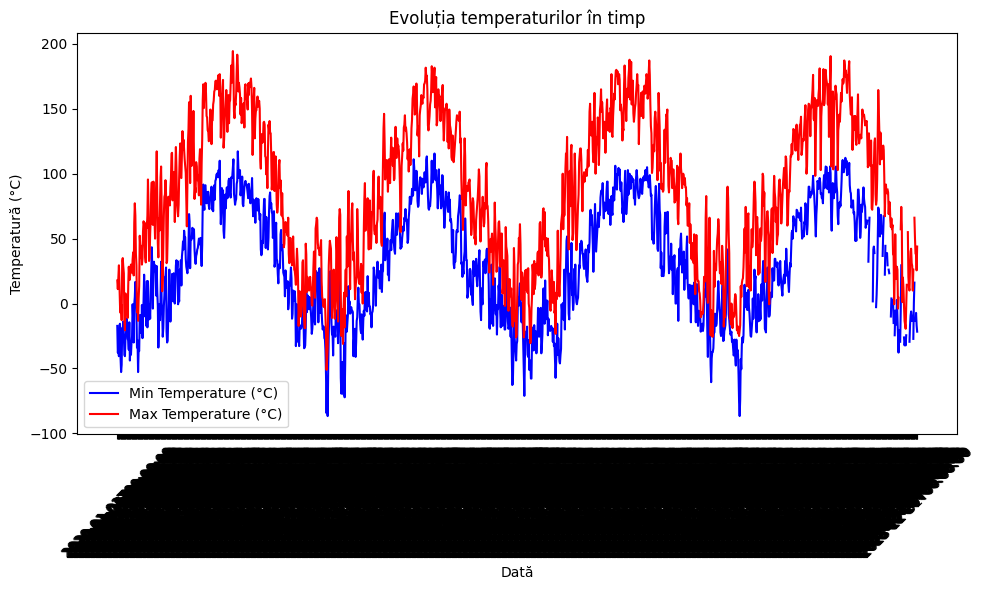

In [99]:
import matplotlib.pyplot as plt

# Setăm dimensiunile graficului
plt.figure(figsize=(10, 6))

# Adăugăm datele pentru temperaturile minime și maxime în grafic
plt.plot(df['Date'], df['Min Temperature (C)'], label='Min Temperature (°C)', color='blue')
plt.plot(df['Date'], df['Max Temperature (C)'], label='Max Temperature (°C)', color='red')

# Adăugăm titlul și etichetele axelor
plt.title('Evoluția temperaturilor în timp')
plt.xlabel('Dată')
plt.ylabel('Temperatură (°C)')

# Rotim etichetele axei x pentru a le face mai ușor de citit
plt.xticks(rotation=45)

# Adăugăm o legendă pentru a indica culorile
plt.legend()

# Afișăm graficul
plt.tight_layout()
plt.show()


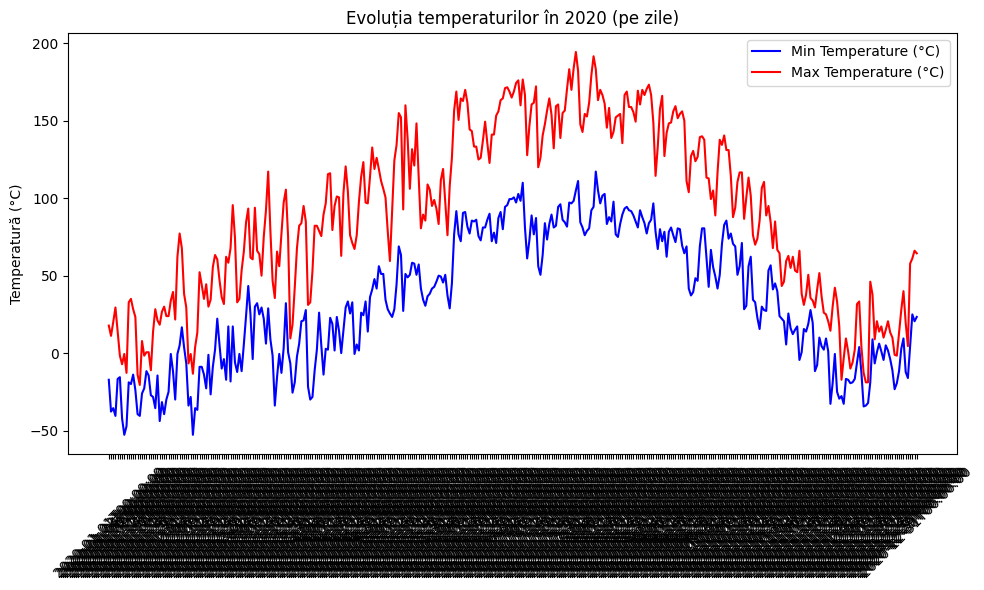

In [101]:
# Filtrăm datele pentru anul 2020
df_2020 = df[df['Date'].str.startswith('2020')]

# Setăm dimensiunile graficului
plt.figure(figsize=(10, 6))

# Adăugăm datele pentru temperaturile minime și maxime în grafic
plt.plot(df_2020['Date'], df_2020['Min Temperature (C)'], label='Min Temperature (°C)', color='blue')
plt.plot(df_2020['Date'], df_2020['Max Temperature (C)'], label='Max Temperature (°C)', color='red')

# Adăugăm titlul și etichetele axelor
plt.title('Evoluția temperaturilor în 2020 (pe zile)')

plt.ylabel('Temperatură (°C)')

# Rotim etichetele axei x pentru a le face mai ușor de citit
plt.xticks(rotation=45)

# Adăugăm o legendă pentru a indica culorile
plt.legend()

# Afișăm graficul
plt.tight_layout()
plt.show()


<ipython-input-102-c5278807df86>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_avg_temps = df_2020.groupby('YearMonth').mean()


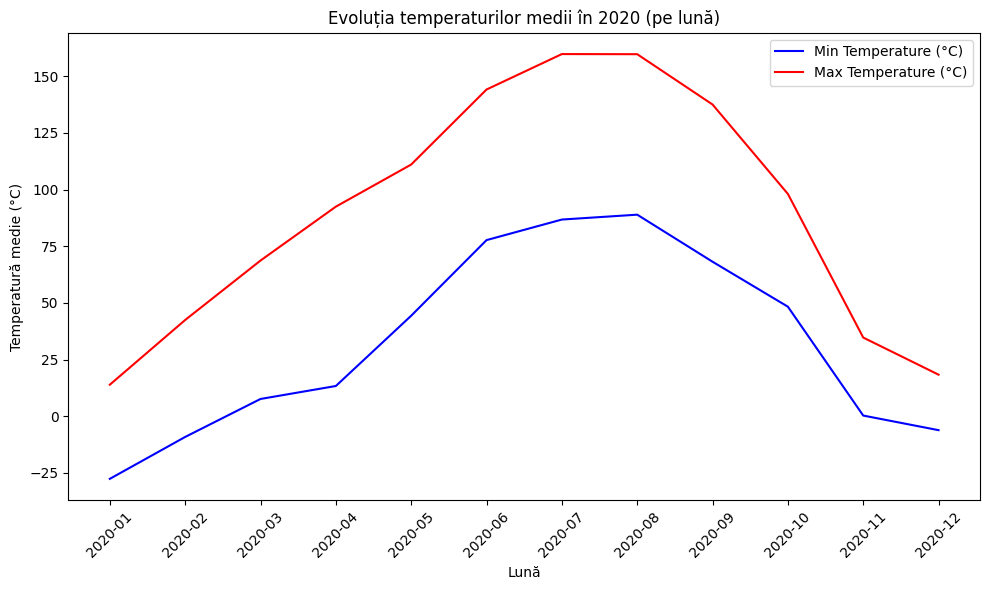

In [102]:
# Extragem anul și luna din coloana 'Date'
df['YearMonth'] = df['Date'].str[:7]

# Filtrăm datele pentru anul 2020
df_2020 = df[df['Date'].str.startswith('2020')]

# Calculăm temperatura medie pentru fiecare lună
monthly_avg_temps = df_2020.groupby('YearMonth').mean()

# Setăm dimensiunile graficului
plt.figure(figsize=(10, 6))

# Adăugăm datele pentru temperatura medie în grafic
plt.plot(monthly_avg_temps.index, monthly_avg_temps['Min Temperature (C)'], label='Min Temperature (°C)', color='blue')
plt.plot(monthly_avg_temps.index, monthly_avg_temps['Max Temperature (C)'], label='Max Temperature (°C)', color='red')

# Adăugăm titlul și etichetele axelor
plt.title('Evoluția temperaturilor medii în 2020 (pe lună)')
plt.xlabel('Lună')
plt.ylabel('Temperatură medie (°C)')

# Rotim etichetele axei x pentru a le face mai ușor de citit
plt.xticks(rotation=45)

# Adăugăm o legendă pentru a indica culorile
plt.legend()

# Afișăm graficul
plt.tight_layout()
plt.show()


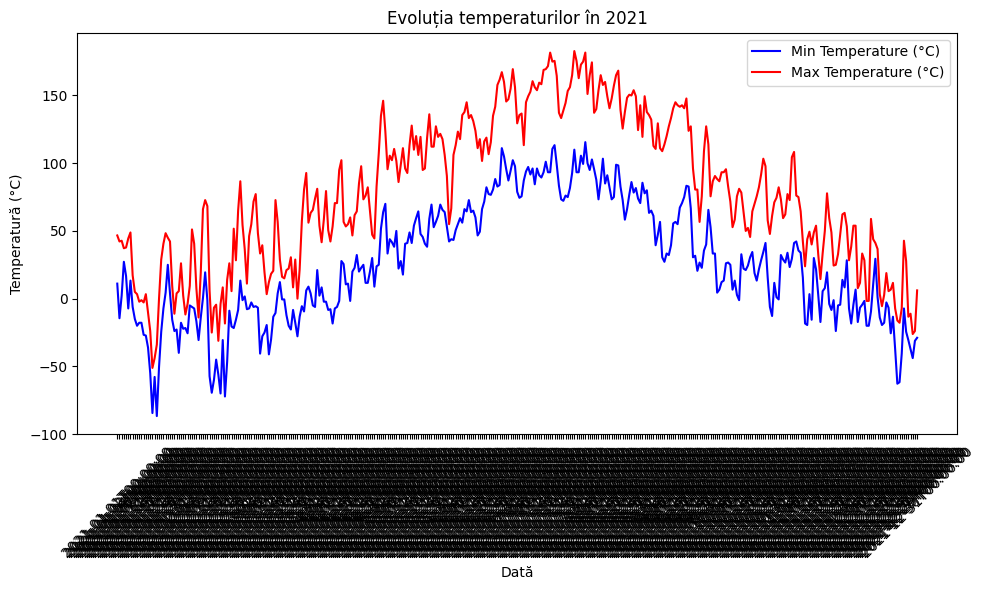

In [108]:
# Filtrăm datele pentru anul 2021
df_2021 = df[df['Date'].str.startswith('2021')]

# Setăm dimensiunile graficului
plt.figure(figsize=(10, 6))

# Adăugăm datele pentru temperaturile minime și maxime în grafic
plt.plot(df_2021['Date'], df_2021['Min Temperature (C)'], label='Min Temperature (°C)', color='blue')
plt.plot(df_2021['Date'], df_2021['Max Temperature (C)'], label='Max Temperature (°C)', color='red')

# Adăugăm titlul și etichetele axelor
plt.title('Evoluția temperaturilor în 2021')
plt.xlabel('Dată')
plt.ylabel('Temperatură (°C)')

# Rotim etichetele axei x pentru a le face mai ușor de citit
plt.xticks(rotation=45)

# Adăugăm o legendă pentru a indica culorile
plt.legend()

# Afișăm graficul
plt.tight_layout()
plt.show()


<ipython-input-111-c36c1f4972b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021['YearMonth'] = df_2021['Date'].str[:7]


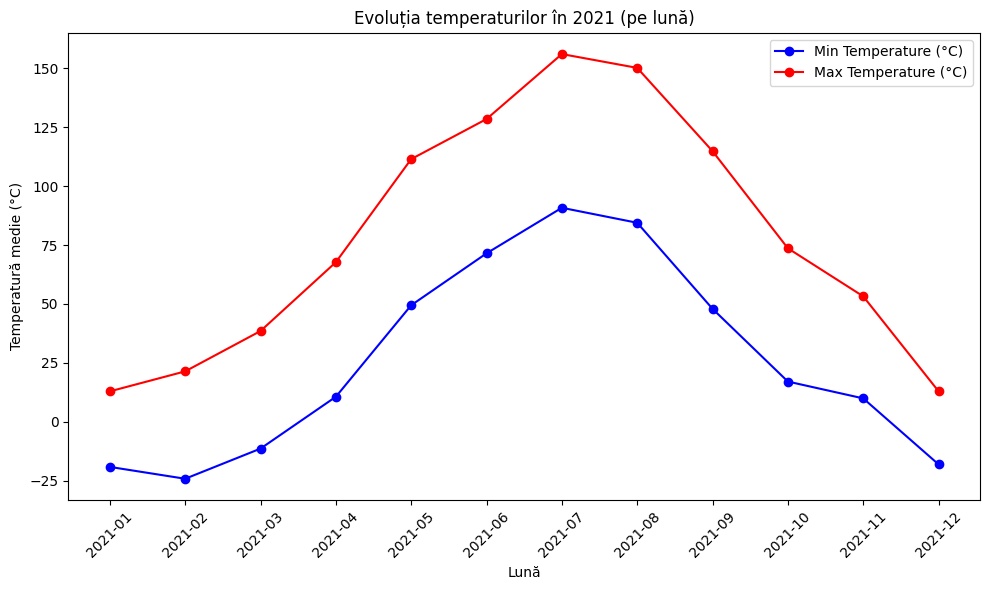

In [111]:
# Filtrăm datele pentru anul 2021
df_2021 = df[df['Date'].str.startswith('2021')]

# Extragem anul și luna din coloana 'Date'
df_2021['YearMonth'] = df_2021['Date'].str[:7]

# Calculăm temperatura medie lunară pentru temperaturile minime și maxime
monthly_avg_min_temps_2021 = df_2021.groupby('YearMonth')['Min Temperature (C)'].mean()
monthly_avg_max_temps_2021 = df_2021.groupby('YearMonth')['Max Temperature (C)'].mean()

# Setăm dimensiunile graficului
plt.figure(figsize=(10, 6))

# Adăugăm datele pentru temperatura medie lunară a temperaturilor minime și maxime în grafic
plt.plot(monthly_avg_min_temps_2021.index, monthly_avg_min_temps_2021, label='Min Temperature (°C)', color='blue', marker='o')
plt.plot(monthly_avg_max_temps_2021.index, monthly_avg_max_temps_2021, label='Max Temperature (°C)', color='red', marker='o')

# Adăugăm titlul și etichetele axelor
plt.title('Evoluția temperaturilor în 2021 (pe lună)')
plt.xlabel('Lună')
plt.ylabel('Temperatură medie (°C)')

# Rotim etichetele axei x pentru a le face mai ușor de citit
plt.xticks(rotation=45)

# Adăugăm o legendă pentru a indica culorile și tipurile de temperaturi
plt.legend()

# Afișăm graficul
plt.tight_layout()
plt.show()


<ipython-input-109-4078fd37fe08>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['YearMonth'] = df_2022['Date'].str[:7]


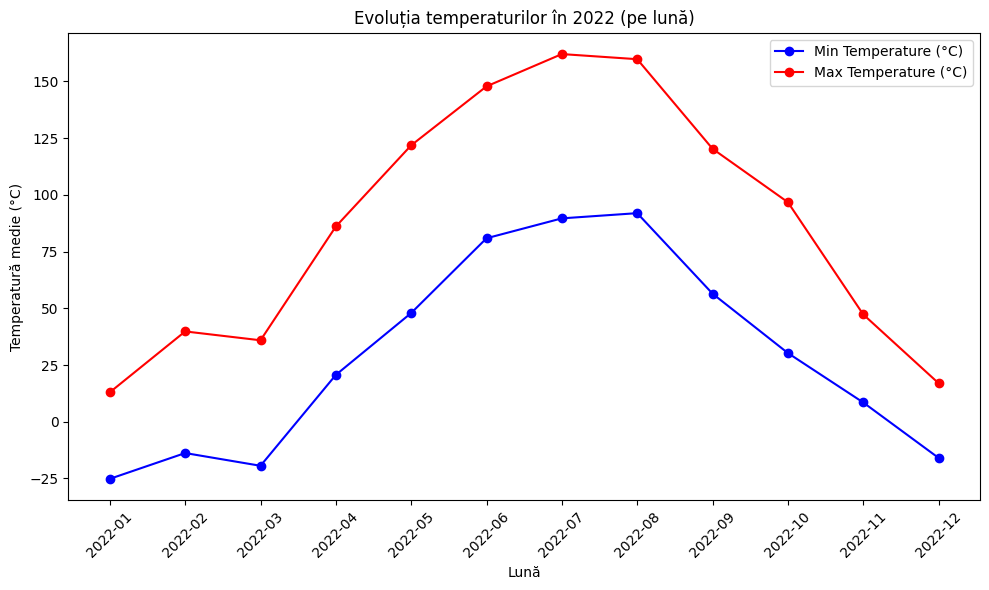

In [109]:
# Filtrăm datele pentru anul 2022
df_2022 = df[df['Date'].str.startswith('2022')]

# Extragem anul și luna din coloana 'Date'
df_2022['YearMonth'] = df_2022['Date'].str[:7]

# Calculăm temperatura medie lunară pentru temperaturile minime și maxime
monthly_avg_min_temps_2022 = df_2022.groupby('YearMonth')['Min Temperature (C)'].mean()
monthly_avg_max_temps_2022 = df_2022.groupby('YearMonth')['Max Temperature (C)'].mean()

# Setăm dimensiunile graficului
plt.figure(figsize=(10, 6))

# Adăugăm datele pentru temperatura medie lunară a temperaturilor minime și maxime în grafic
plt.plot(monthly_avg_min_temps_2022.index, monthly_avg_min_temps_2022, label='Min Temperature (°C)', color='blue', marker='o')
plt.plot(monthly_avg_max_temps_2022.index, monthly_avg_max_temps_2022, label='Max Temperature (°C)', color='red', marker='o')

# Adăugăm titlul și etichetele axelor
plt.title('Evoluția temperaturilor în 2022 (pe lună)')
plt.xlabel('Lună')
plt.ylabel('Temperatură medie (°C)')

# Rotim etichetele axei x pentru a le face mai ușor de citit
plt.xticks(rotation=45)

# Adăugăm o legendă pentru a indica culorile și tipurile de temperaturi
plt.legend()

# Afișăm graficul
plt.tight_layout()
plt.show()


<ipython-input-103-238e34b458e5>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_avg_temps_2020 = df_2020.groupby('YearMonth').mean()
<ipython-input-103-238e34b458e5>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_avg_temps_2021 = df_2021.groupby('YearMonth').mean()
<ipython-input-103-238e34b458e5>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_avg_temps_2022 = df_2022.groupby('YearMont

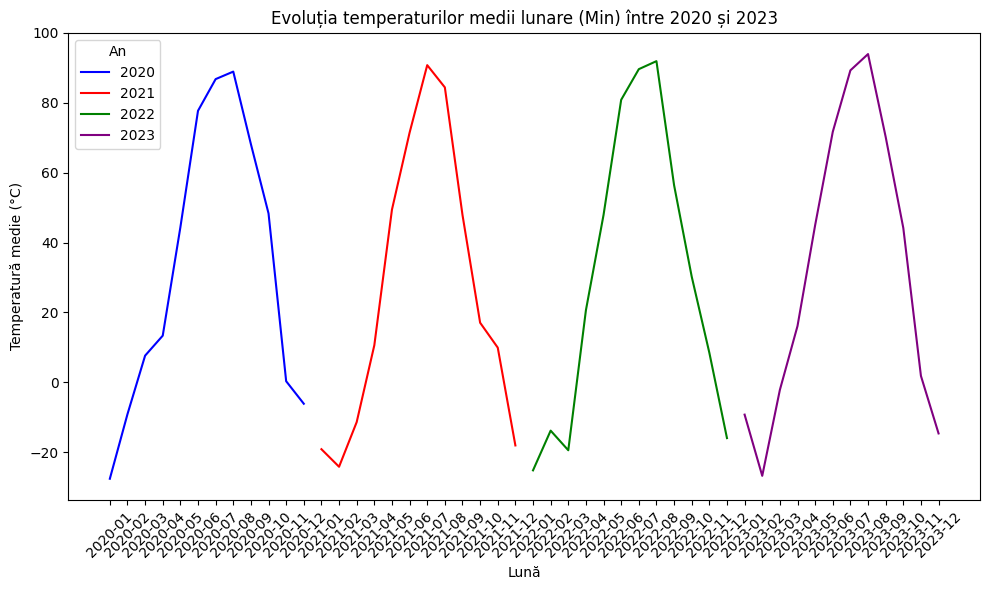

In [103]:
# Extragem anul și luna din coloana 'Date'
df['YearMonth'] = df['Date'].str[:7]

# Filtrăm datele pentru fiecare an
df_2020 = df[df['Date'].str.startswith('2020')]
df_2021 = df[df['Date'].str.startswith('2021')]
df_2022 = df[df['Date'].str.startswith('2022')]
df_2023 = df[df['Date'].str.startswith('2023')]

# Calculăm temperatura medie pentru fiecare lună și pentru fiecare an
monthly_avg_temps_2020 = df_2020.groupby('YearMonth').mean()
monthly_avg_temps_2021 = df_2021.groupby('YearMonth').mean()
monthly_avg_temps_2022 = df_2022.groupby('YearMonth').mean()
monthly_avg_temps_2023 = df_2023.groupby('YearMonth').mean()

# Setăm dimensiunile graficului
plt.figure(figsize=(10, 6))

# Adăugăm datele pentru temperatura medie în grafic pentru fiecare an
plt.plot(monthly_avg_temps_2020.index, monthly_avg_temps_2020['Min Temperature (C)'], label='2020', color='blue')
plt.plot(monthly_avg_temps_2021.index, monthly_avg_temps_2021['Min Temperature (C)'], label='2021', color='red')
plt.plot(monthly_avg_temps_2022.index, monthly_avg_temps_2022['Min Temperature (C)'], label='2022', color='green')
plt.plot(monthly_avg_temps_2023.index, monthly_avg_temps_2023['Min Temperature (C)'], label='2023', color='purple')

# Adăugăm titlul și etichetele axelor
plt.title('Evoluția temperaturilor medii lunare (Min) între 2020 și 2023')
plt.xlabel('Lună')
plt.ylabel('Temperatură medie (°C)')

# Rotim etichetele axei x pentru a le face mai ușor de citit
plt.xticks(rotation=45)

# Adăugăm o legendă pentru a indica culorile și anii corespunzători
plt.legend(title='An')

# Afișăm graficul
plt.tight_layout()
plt.show()


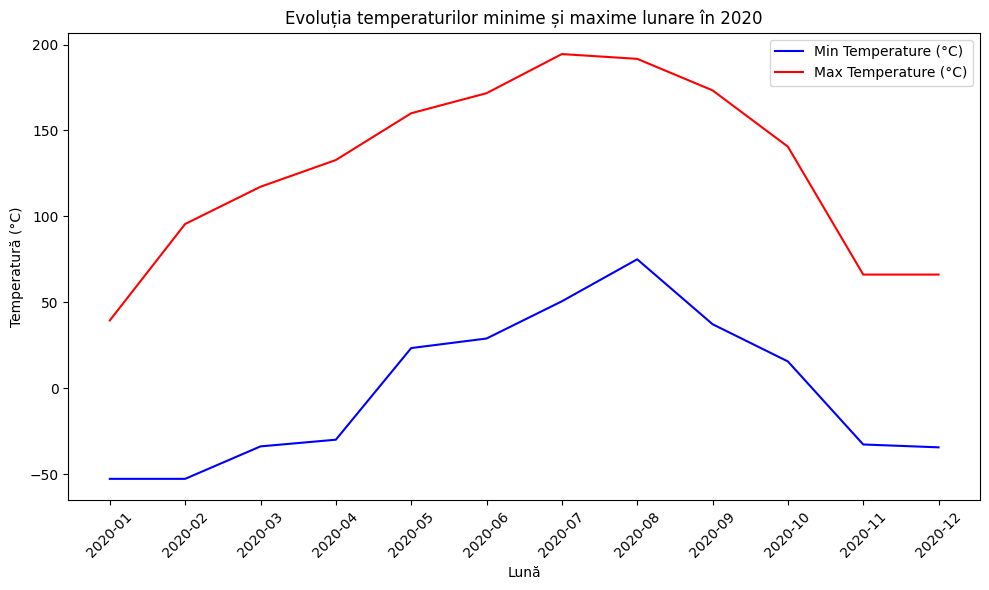

In [104]:
# Filtrăm datele pentru anul 2020
df_2020 = df[df['Date'].str.startswith('2020')]

# Calculăm temperatura minimă și temperatura maximă lunară pentru anul 2020
monthly_min_temps_2020 = df_2020.groupby('YearMonth')['Min Temperature (C)'].min()
monthly_max_temps_2020 = df_2020.groupby('YearMonth')['Max Temperature (C)'].max()

# Setăm dimensiunile graficului
plt.figure(figsize=(10, 6))

# Adăugăm datele pentru temperatura minimă și temperatura maximă în grafic pentru anul 2020
plt.plot(monthly_min_temps_2020.index, monthly_min_temps_2020, label='Min Temperature (°C)', color='blue')
plt.plot(monthly_max_temps_2020.index, monthly_max_temps_2020, label='Max Temperature (°C)', color='red')

# Adăugăm titlul și etichetele axelor
plt.title('Evoluția temperaturilor minime și maxime lunare în 2020')
plt.xlabel('Lună')
plt.ylabel('Temperatură (°C)')

# Rotim etichetele axei x pentru a le face mai ușor de citit
plt.xticks(rotation=45)

# Adăugăm o legendă pentru a indica culorile și tipurile de temperaturi
plt.legend()

# Afișăm graficul
plt.tight_layout()
plt.show()


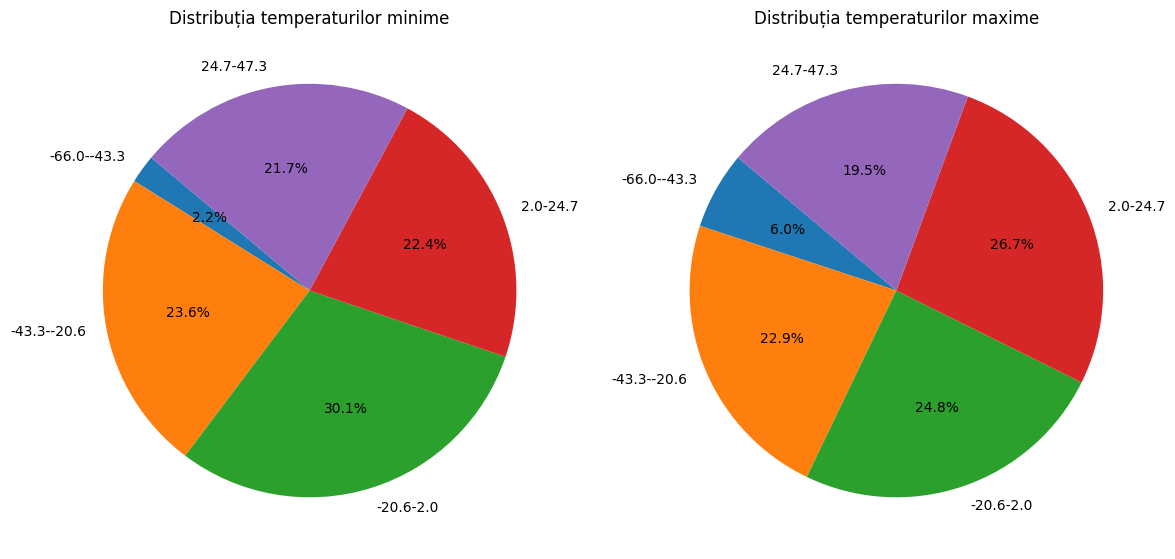

In [107]:
# Calculăm numărul de luni în care temperatura minimă și temperatura maximă se încadrează în diferite intervale
min_temp_bins = pd.cut(df_years['Min Temperature (C)'], bins=5)
max_temp_bins = pd.cut(df_years['Max Temperature (C)'], bins=5)

min_temp_counts = min_temp_bins.value_counts().sort_index()
max_temp_counts = max_temp_bins.value_counts().sort_index()

# Setăm etichetele pentru intervalele de temperatură
labels = [f'{bin.left:.1f}-{bin.right:.1f}' for bin in min_temp_counts.index]

# Creăm subfigurile pentru două grafice tip pie
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficul pentru temperaturile minime
axs[0].pie(min_temp_counts, labels=labels, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribuția temperaturilor minime')

# Graficul pentru temperaturile maxime
axs[1].pie(max_temp_counts, labels=labels, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Distribuția temperaturilor maxime')

# Afișăm graficul
plt.tight_layout()
plt.show()


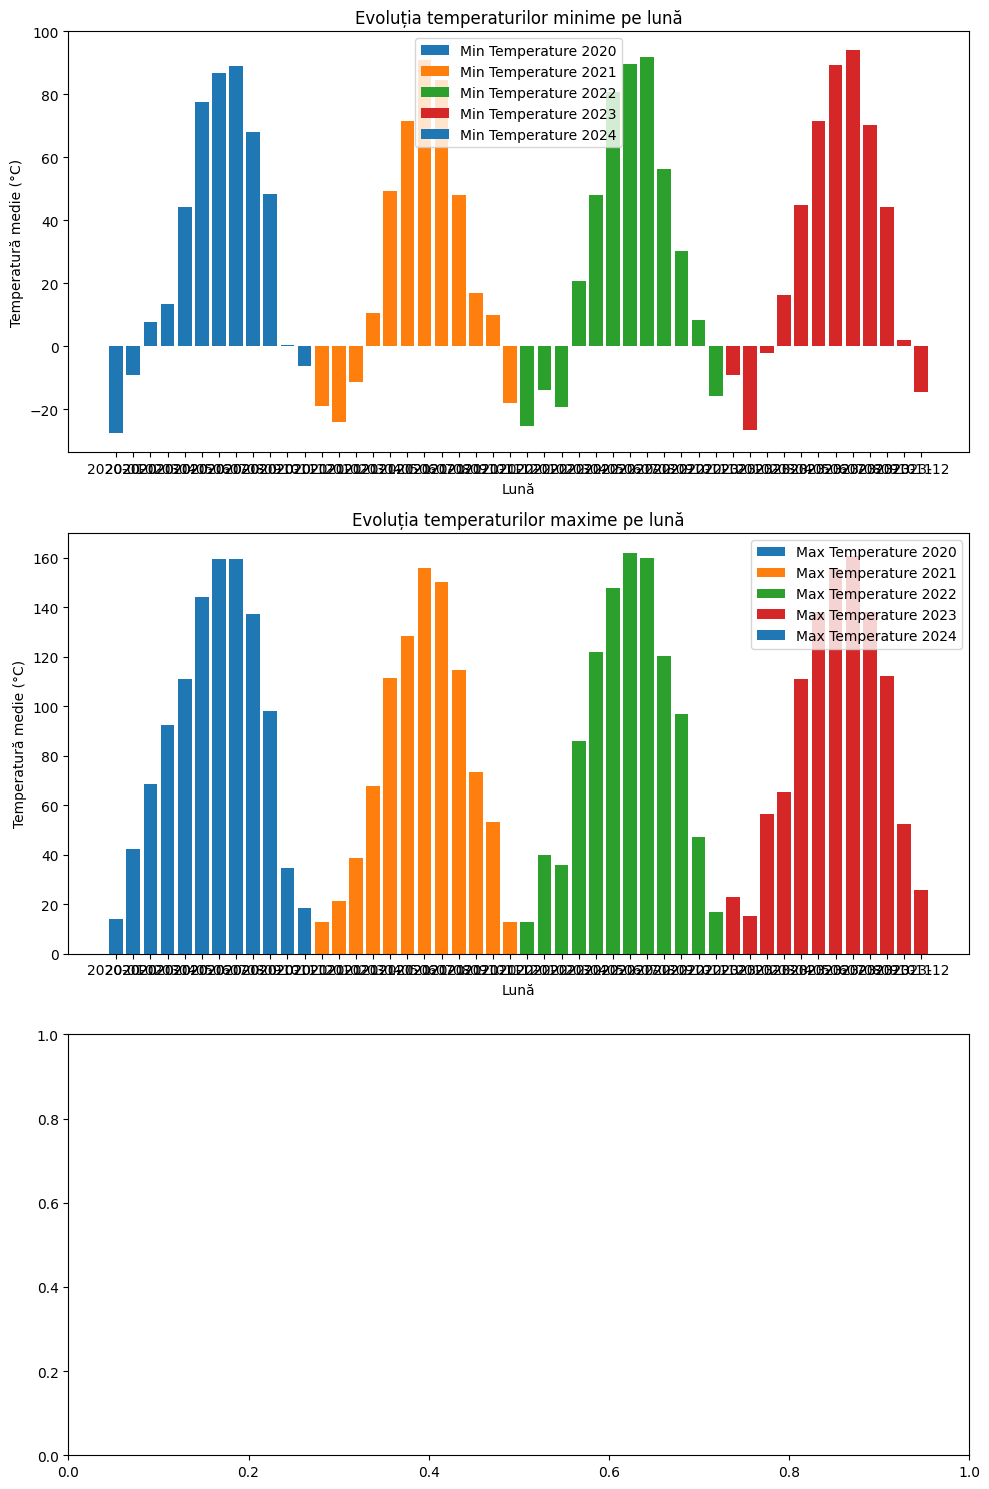

In [114]:
# Setăm dimensiunile graficelor
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Evoluția temperaturilor minime
for year in range(2020, 2025):
    df_year = df[df['Date'].str.startswith(str(year))]
    monthly_avg_min_temps_year = df_year.groupby(['YearMonth'])['Min Temperature (C)'].mean()
    axes[0].bar(monthly_avg_min_temps_year.index, monthly_avg_min_temps_year, label=f'Min Temperature {year}')

axes[0].set_title('Evoluția temperaturilor minime pe lună')
axes[0].set_xlabel('Lună')
axes[0].set_ylabel('Temperatură medie (°C)')
axes[0].legend()

# Evoluția temperaturilor maxime
for year in range(2020, 2025):
    df_year = df[df['Date'].str.startswith(str(year))]
    monthly_avg_max_temps_year = df_year.groupby(['YearMonth'])['Max Temperature (C)'].mean()
    axes[1].bar(monthly_avg_max_temps_year.index, monthly_avg_max_temps_year, label=f'Max Temperature {year}')

axes[1].set_title('Evoluția temperaturilor maxime pe lună')
axes[1].set_xlabel('Lună')
axes[1].set_ylabel('Temperatură medie (°C)')
axes[1].legend()

# Afișăm graficele
plt.tight_layout()
plt.show()
